In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd

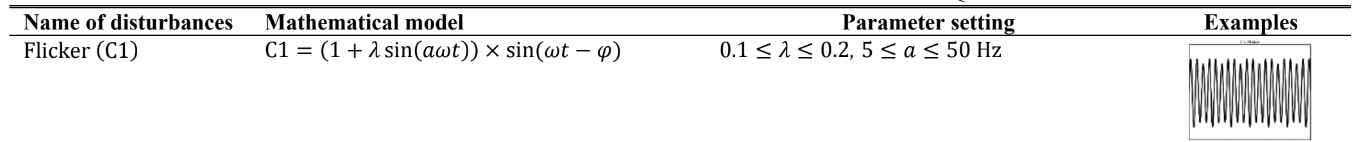

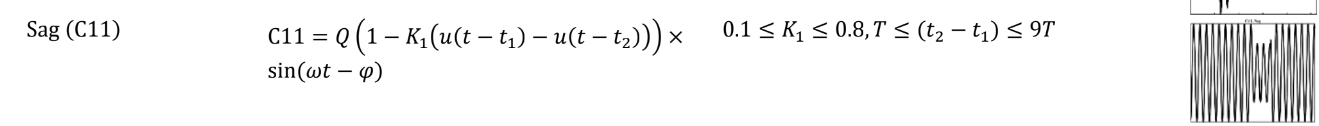

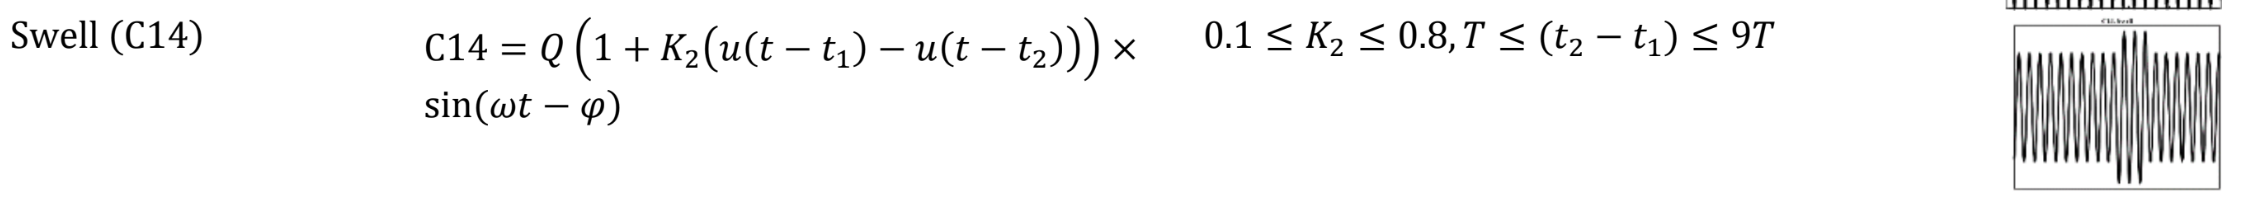

In [2]:
def generate_flicker(Q=1, duration=1, sample_rate=12800):
    lb = np.random.uniform(0.1, 0.2)
    alpha = np.random.uniform(5, 50)
    alpha_rad = 2 * np.pi * alpha
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    fundamental_freq = 50
    omega = 2 * np.pi * fundamental_freq
    phi = np.random.uniform(0, 2 * np.pi)
    modulation = 1 + lb * np.sin(alpha_rad * t)
    base_signal = np.sin(omega * t + phi)
    C_flicker = Q * modulation * base_signal
    return C_flicker

In [3]:
def generate_sag(Q=1, T=0.02, duration=1, sample_rate=12800):
    if duration < 9 * T:
        raise ValueError("Duration must be at least 9 times T to satisfy t2 > t1 constraints.")
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    K1 = np.random.uniform(0.1, 0.8)
    fundamental_freq = 50
    omega = 2 * np.pi * fundamental_freq
    phi = np.random.uniform(0, 2 * np.pi)
    t1 = np.random.uniform(0, duration - 9 * T)
    t2 = np.random.uniform(t1 + T, t1 + 9 * T)
    step1 = np.heaviside(t - t1, 1)
    step2 = np.heaviside(t - t2, 1)
    mod_sag = 1 - K1 * (step1 - step2)
    C_sag = Q * mod_sag * np.sin(omega * t - phi)
    return C_sag

In [4]:
def generate_swell(Q=1, T=0.02, duration=1, sample_rate=12800):
    if duration < 9 * T:
        raise ValueError("Duration must be at least 9 times T to satisfy t2 > t1 constraints.")
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    K2 = np.random.uniform(0.1, 0.8)
    fundamental_freq = 50
    omega = 2 * np.pi * fundamental_freq
    phi = np.random.uniform(0, 2 * np.pi)
    t1 = np.random.uniform(0, duration - 9 * T)
    t2 = np.random.uniform(t1 + T, t1 + 9 * T)
    step1 = np.heaviside(t - t1, 1)
    step2 = np.heaviside(t - t2, 1)
    mod_swell = 1 + K2 * (step1 - step2)
    C_swell = Q * mod_swell * np.sin(omega * t - phi)
    return C_swell

In [5]:
def generate_multiple_signals(num_signals_per_type=500, Q=1, T=0.02, duration=1, sample_rate=12800):
    signals = []
    labels = []

    disturbance_types = {
        'flicker': generate_flicker,
        'sag': generate_sag,
        'swell': generate_swell
    }
    label_map = {
        'flicker': 'C1',
        'sag': 'C11',
        'swell': 'C14'
    }
    for disturbance, func in disturbance_types.items():
        print(f"Generating {num_signals_per_type} '{disturbance}' signals...")
        for _ in tqdm(range(num_signals_per_type), desc=f"Generating {disturbance} signals"):
            if disturbance == 'flicker':
                signal = func(Q=Q, duration=duration, sample_rate=sample_rate)
            else:
                signal = func(Q=Q, T=T, duration=duration, sample_rate=sample_rate)
            signals.append(signal)
            labels.append(label_map[disturbance])

    signals_array = np.array(signals)

    num_samples = signals_array.shape[1]
    sample_columns = [f'sample_{i}' for i in range(num_samples)]

    df_all = pd.DataFrame(signals_array, columns=sample_columns)

    df_all['label'] = labels

    return df_all

In [6]:
df = generate_multiple_signals(num_signals_per_type=3000, Q=1, T=0.02, duration=1, sample_rate=12800)

Generating 3000 'flicker' signals...


Generating flicker signals: 100%|██████████████████████████████████████| 3000/3000 [00:00<00:00, 3357.96it/s]


Generating 3000 'sag' signals...


Generating sag signals: 100%|██████████████████████████████████████████| 3000/3000 [00:00<00:00, 4001.02it/s]


Generating 3000 'swell' signals...


Generating swell signals: 100%|████████████████████████████████████████| 3000/3000 [00:00<00:00, 3997.32it/s]


In [7]:
df.shape

(9000, 12801)

In [ ]:
df.to_csv('signals.csv', index=False)